### Contact on balls inside strike zone

```python
df["ruth"] = (ng"] = (1/2) )* (1 + 0.2 * df["batter_vibes"]) * df["batter_multiplier"] *

dfc["ballpark_sum"] = (dfc["fort_center"]+ 3*dfc["visc_center"] - 6*dfc["fwd_center"]) / 10

dfc["threshold"] = (
    0.8
    - 0.08*dfc["ruth"]
    + 0.16*dfc["ballpark_sum"]
    + 0.16*dfc["combined_batting_1.2"]
)
dfc.loc[(dfc["threshold"] > 0.9), "threshold"] = 0.9
``` (
    df["batter_divinity"]
    + df["batter_musclitude"]
    + df["batter_thwackability"]
    - df["batter_patheticism"]df["pitcher_ruthlessness"]
              * (1 + 0.2*df["pitcher_vibes"])
              * df["pitcher_multiplier"]
             )
df["combined_batti

In [34]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
all_files = glob.glob("../roll_data/*-contact.csv")

df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string", "is_strike": "boolean"}) for f in all_files),
               ignore_index=True)

# seasons = [11, 12, 13, 14]
seasons = [11, 12, 13]
# seasons = [13]
# seasons = [14]
df = df[df['season'].isin(seasons)]
len(df)

308140

In [35]:
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

df["ruth"] = df["pitcher_ruthlessness"] * (1 + 0.2*df["pitcher_vibes"]) * df["pitcher_multiplier"]
df["combined_batting"] = (1/2) * (
    df["batter_divinity"]
    + df["batter_musclitude"]
    + df["batter_thwackability"]
    - df["batter_patheticism"]
) * (1 + 0.2 * df["batter_vibes"]) * df["batter_multiplier"]

In [36]:
dfc = df.copy()
dfc = dfc[dfc["is_strike"] == True]

# dfc = dfc[~((dfc["season"] == 11) & (dfc["day"] == 98))] # bad data here

for exclude_mod in ["GROWTH", "TRAVELING", "SHELLED", "CHUNKY", "SMOOTH", "ON_FIRE"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

dfc = dfc[~(dfc["batting_team_mods"].astype(str).str.contains("O_NO") & (dfc["ball_count"] == 0))]
dfc = dfc[(dfc["pitcher_multiplier"] == 1) & (dfc["batter_multiplier"] == 1)]
dfc_bad = dfc[dfc["combined_batting"] < 0].copy()
dfc = dfc[dfc["combined_batting"] >= 0]

In [37]:
dfc_bad.groupby("batter_name").size()

batter_name
Caleb Novak          451
Chorby Short          78
Combs Estes          129
Concrete Mandible    226
Declan Suzanne       162
Gallup Crueller       35
Morrow Wilson        562
Theo King            144
Wyatt Glover         133
dtype: int64

In [ ]:
dfc.loc[dfc["passed"], "roll"].max()

0.8999969874028093

In [ ]:

dfc["combined_batting_1.5"] = (dfc["combined_batting"])**(1.5)
dfc["combined_batting_0.5"] = (dfc["combined_batting"])**(0.5)
dfc["combined_batting_1.25"] = (dfc["combined_batting"])**(1.25)
dfc["combined_batting_0.25"] = (dfc["combined_batting"])**(0.25)
dfc["combined_batting_1.3"] = (dfc["combined_batting"])**(1.3)
dfc["combined_batting_0.3"] = (dfc["combined_batting"])**(0.3)
dfc["combined_batting_1.2"] = (dfc["combined_batting"])**(1.2)

dfc["grand_center"] = dfc["ballpark_grandiosity"] - 0.5
dfc["fort_center"] = dfc["ballpark_fortification"] - 0.5
dfc["obt_center"] = dfc["ballpark_obtuseness"] - 0.5
dfc["om_center"] = dfc["ballpark_ominousness"] - 0.5
dfc["inc_center"] = dfc["ballpark_inconvenience"] - 0.5
dfc["visc_center"] = dfc["ballpark_viscosity"] - 0.5
dfc["fwd_center"] = dfc["ballpark_forwardness"] - 0.5
dfc["myst_center"] = dfc["ballpark_mysticism"] - 0.5
dfc["elong_center"] = dfc["ballpark_elongation"] - 0.5

dfc["ballpark_sum"] = (dfc["fort_center"] + 3*dfc["visc_center"] - 6*dfc["fwd_center"]) / 10

# we know the intercept is 0.4 in s12/s13 and 0.35 in s14/s15 so special case it here so the fit works across
# dfc.loc[dfc["season"] == 13,"roll"] -= 0.05
# dfc.loc[dfc["season"] == 14,"roll"] -= 0.05

In [ ]:
# dfc_bad = dfc[dfc["batter_name"].isin(hall_of_shame)].copy()
# dfc_good = dfc[~dfc["batter_name"].isin(hall_of_shame)].copy()

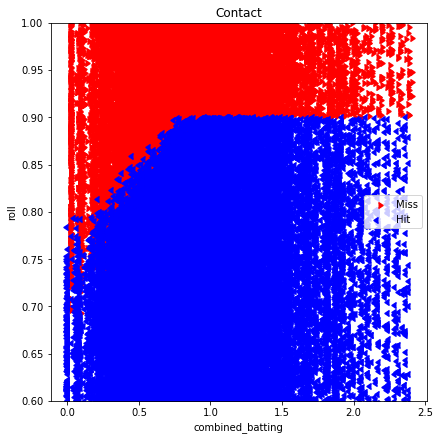

In [ ]:
x_val = "combined_batting"
y_val = "roll"
fig, ax = plt.subplots(1, figsize=(6, 6), layout="constrained")
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Miss",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Hit",
    marker=CARETLEFTBASE,
)


ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Contact")
ax.set_ylim(0.6, 1)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

In [ ]:
X = dfc[
    [
        "roll",
        "season",
        "passed",
        "ruth",
        # "combined_batting_1.5",
        # "combined_batting",
        # "combined_batting_0.5",
        # "combined_batting_1.25",
        "combined_batting_1.2",

        "ballpark_sum",
    ]
].copy()
X = X[X['roll'] < 0.9]

pin_intercept = None
pin_intercept = 0.8
pins = [
    (-0.08, "ruth"),
    (0.16, "ballpark_sum"),
    # (0.06969, "combined_batting_1.2")
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

y = X["passed"]
X = X.drop(["passed", "season"], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model


sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=100000000, tol=1e-12,
                           fit_intercept=pin_intercept is None).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[  6422      0]
 [     0 135710]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      6422
        True       1.00      1.00      1.00    135710

    accuracy                           1.00    142132
   macro avg       1.00      1.00      1.00    142132
weighted avg       1.00      1.00      1.00    142132

1.0


In [ ]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = pin_intercept or -(intercept / coef[0, 0])[0]

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if pair[1] != "roll":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

dfc["threshold"] = (
    0.8
    - 0.08*dfc["ruth"]
    + 0.16*dfc["ballpark_sum"]
    + 0.16*dfc["combined_batting_1.2"]
)
dfc["threshold_plot"] = dfc["threshold"].copy()

dfc.loc[(dfc["threshold"] > 0.9), "threshold"] = 0.9

# for i in range(2, 6):
#     print(coef_list[i+4]/coef_list[i])

intercept: 0.8
(-0.08, 'ruth')
(0.16, 'ballpark_sum')
(0.1600015733952287, 'combined_batting_1.2')


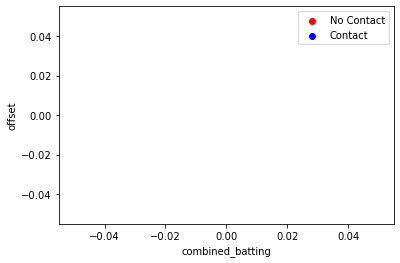

In [ ]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "combined_batting"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Contact",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Contact",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

In [ ]:
pd.set_option("display.max_columns", None)
table = outliers[
    [
        "passed",
        "offset",
        # "event_type",
        # "weather",
        # "batter_laserlikeness",
        "roll",
        "threshold",
        "ruth",
        "combined_batting_1.2",
        # "combined_batting",
        # "combined_batting_0.5",
        # "combined_batting_1.25",
        # "combined_batting_0.25",
        "pitcher_multiplier",
        "batter_multiplier",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "fielder_roll",
    ]
]
print(len(table))
table.sort_values("offset", ascending=False)[0:10]

0


,passed,offset,roll,threshold,ruth,combined_batting_1.2,pitcher_multiplier,batter_multiplier,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count


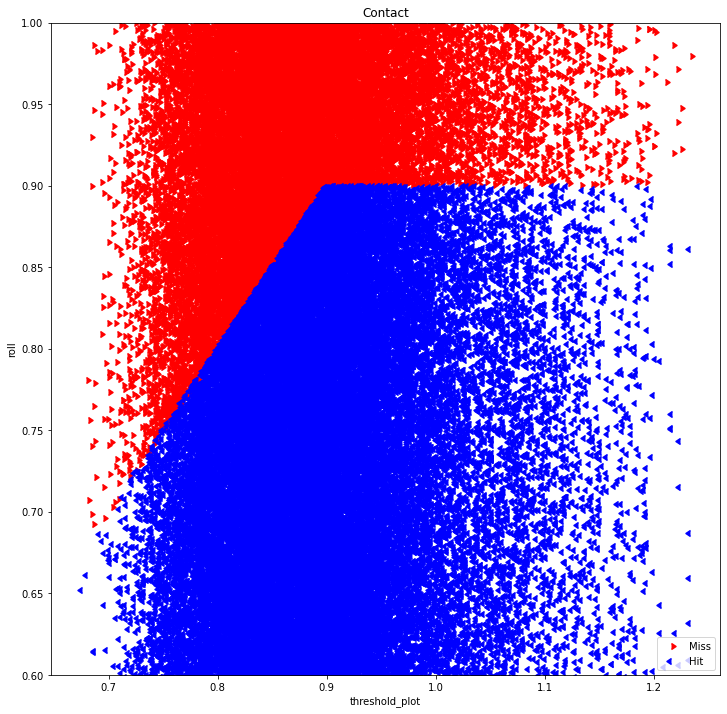

In [ ]:
x_val = "threshold_plot"
# x_val = "combined_batting_1.2"
y_val = "roll"
fig, ax = plt.subplots(1, figsize=(12, 12))

ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Miss",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Hit",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Contact")
ax.set_ylim(0.6, 1)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend(loc="lower right")

In [ ]:
# outliers_scatter = outliers.loc[:, [
#     "offset",
#     "batter_buoyancy",
#     "batter_divinity",
#     "batter_martyrdom",
#     "batter_moxie",
#     "batter_musclitude",
#     "batter_patheticism",
#     "batter_thwackability",
#     "batter_tragicness",
#     "batter_vibes",
#     "pitcher_ruthlessness",
#     "pitcher_overpowerment",
#     "pitcher_unthwackability",
#     "pitcher_shakespearianism",
#     "pitcher_suppression",
#     "pitcher_coldness",
#     "pitcher_vibes"
# ]].copy()

In [ ]:
# scatter_matrix(outliers_scatter, alpha=0.2, figsize=(10, 10), diagonal="kde");

In [ ]:
# for col in [
#     "batter_buoyancy",
#     "batter_divinity",
#     "batter_martyrdom",
#     "batter_moxie",
#     "batter_musclitude",
#     "batter_patheticism",
#     "batter_thwackability",
#     "batter_tragicness",
#     "batter_vibes",
#     "pitcher_ruthlessness",
#     "pitcher_overpowerment",
#     "pitcher_unthwackability",
#     "pitcher_shakespearianism",
#     "pitcher_suppression",
#     "pitcher_coldness",
#     "pitcher_vibes"
# ]:
#     plt.figure()
#     plt.plot(outliers_scatter[col], outliers_scatter["offset"],'o')
#     plt.xlabel(col)
#     plt.ylabel('offset')